# Select TensorFlow 1

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.layers import conv2d, conv2d_transpose, batch_normalization
from tensorflow.nn import tanh, sigmoid, leaky_relu, sigmoid_cross_entropy_with_logits
from tensorflow.train import AdamOptimizer

# Defining model layers

### Defining generator model for the GAN 

In [3]:
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = leaky_relu(batch_normalization(conv1, training=isTrain))

        # 2nd hidden layer
        conv2 = conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = leaky_relu(batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        conv3 = conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = leaky_relu(batch_normalization(conv3, training=isTrain))

        # 4th hidden layer
        conv4 = conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = leaky_relu(batch_normalization(conv4, training=isTrain))

        # output layer
        conv5 = conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        output = tanh(conv5)

        return output

### Defining discriminator model for the GAN 

In [4]:
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = leaky_relu(conv1)

        # 2nd hidden layer
        conv2 = conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        conv3 = conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain))

        # 4th hidden layer
        conv4 = conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = leaky_relu(tf.layers.batch_normalization(conv4, training=isTrain))

        # output layer
        conv5 = conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        output = sigmoid(conv5)

        return output, conv5

# Defining GAN models

In [5]:
def create_GAN(x, z, isTrain):
  G_sample = generator(z, isTrain)
  D_real, D_real_logits= discriminator(x, isTrain)
  D_fake, D_fake_logits = discriminator(G_sample, isTrain, reuse=True)
  return G_sample, D_real, D_real_logits ,D_fake, D_fake_logits

# Defining losses for the network models

In [6]:
def create_loss_functions(D_real_logits, D_fake_logits, batch_size):
  D_loss_real = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
  D_loss_fake = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
  D_loss = D_loss_real + D_loss_fake
  G_loss = tf.reduce_mean(
      sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))
  return D_loss, G_loss

# Util functions

In [7]:
#Define the plot of sample result function
def plot_samples(samples, epoch=None, n=5):
  if epoch == None:
    epoch = np.shape(samples)[0]-1
  fig = plt.figure(figsize=(8, 8))
  for i in range(n*n):
      ax = plt.subplot(n, n, i + 1)
      ax.imshow(samples[epoch][i].reshape(64,64))
      ax.axis("off")
  fig.subplots_adjust(hspace=0.025, wspace=0.025)
  plt.show()

In [8]:
#Define the plot of the training loss
def plot_training_loss(training_loss):
  plt.plot(training_loss['G_losses'], label='G_loss' )
  plt.plot(training_loss['D_losses'], label='D_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=1)
  plt.grid(True) 
  plt.show()

# Loading data, defining training parameters and input variables

In [9]:
# training parameters
lr = 0.0002
batch_size = 100
num_epochs = 100

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# input variables
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

# Initializing the GAN network

In [10]:
#Create GAN 
G_z, D_real, D_real_logits, D_fake, D_fake_logits = create_GAN(x, z, isTrain)

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


# Initializing losses for each network

In [11]:
#Create loss function for each network
D_loss, G_loss = create_loss_functions(D_real_logits,D_fake_logits,batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model Setup

In [12]:
# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# Optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


# Resize the data to be 64 * 64
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()

# Normalize the data to be from -1:1 
train_set = (train_set - 0.5) * 2 

#Initialize the training loss 
training_loss = {}
training_loss['D_losses'] = []
training_loss['G_losses'] = []

#Take a slice of the data to train on it to reduce the time of the training 
data_slice = 2000
train_set = train_set[:data_slice,:]

#Initialize the training loss 
training_loss = {}
training_loss['D_losses'] = []
training_loss['G_losses'] = []

#Initialize samples that will be used for ploting
samples=[]


# Training model

In [13]:
#Loop over the number of epochs 
for epoch in range(num_epochs):
    #Initialize discriminator loss (D_losses) and generator loss (G_losses) with an empty list in each epoch
    D_losses = []
    G_losses = []

    #Loop over the number of mini batches 
    mini_batches = train_set.shape[0] // batch_size
    for batch in range(mini_batches):

      x_batch = train_set[batch*batch_size:(batch+1)*batch_size]
      z_batch = np.random.normal(0, 1, (batch_size, 1, 1, 100))
      #Update discriminator, calculate and append its loss
      dloss, _ = sess.run([D_loss, D_optim], {x: x_batch, z: z_batch, isTrain: True})
      D_losses.append(np.mean(dloss))

      z_batch = np.random.normal(0, 1, (batch_size, 1, 1, 100))
      #Update generator, calculate and append its loss
      gloss, _ = sess.run([G_loss, G_optim], {z: z_batch, x: x_batch, isTrain: True})
      G_losses.append(gloss)

    fixed_z = np.random.normal(0, 1, (25, 1, 1, 100))
    #Generate sample and append it to samples 
    sample= sess.run(G_z, {z: fixed_z, isTrain: False})
    samples.append(sample)
    
    #Append the training loss of each epoch 
    training_loss['D_losses'].append(np.mean(D_losses))
    training_loss['G_losses'].append(np.mean(G_losses))

    #Print the training loss in each epoch by taking the average of batches losses 
    print("Epoch: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(epoch+1,
                                                                              np.mean(D_losses),
                                                                              np.mean(G_losses)))
sess.close()

Epoch: 1	 Discriminator loss: 1.4303	 Generator loss: 25.7937
Epoch: 2	 Discriminator loss: 3.6448	 Generator loss: 18.0414
Epoch: 3	 Discriminator loss: 0.7748	 Generator loss: 4.2698
Epoch: 4	 Discriminator loss: 1.2073	 Generator loss: 4.4787
Epoch: 5	 Discriminator loss: 0.7365	 Generator loss: 3.4684
Epoch: 6	 Discriminator loss: 0.8620	 Generator loss: 3.3936
Epoch: 7	 Discriminator loss: 0.9867	 Generator loss: 3.1538
Epoch: 8	 Discriminator loss: 0.2984	 Generator loss: 3.1683
Epoch: 9	 Discriminator loss: 1.1547	 Generator loss: 3.1136
Epoch: 10	 Discriminator loss: 0.2660	 Generator loss: 3.1962
Epoch: 11	 Discriminator loss: 0.2312	 Generator loss: 3.5137
Epoch: 12	 Discriminator loss: 3.5238	 Generator loss: 3.5100
Epoch: 13	 Discriminator loss: 0.9300	 Generator loss: 1.9607
Epoch: 14	 Discriminator loss: 0.6688	 Generator loss: 2.3161
Epoch: 15	 Discriminator loss: 0.3367	 Generator loss: 2.9944
Epoch: 16	 Discriminator loss: 0.2866	 Generator loss: 3.3778
Epoch: 17	 Disc

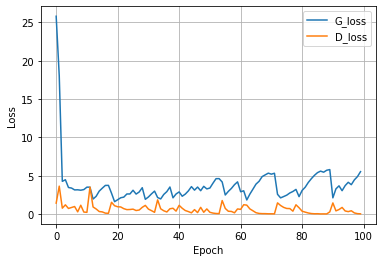

In [14]:
#Plot training loss for both generator and discriminator 
plot_training_loss(training_loss)

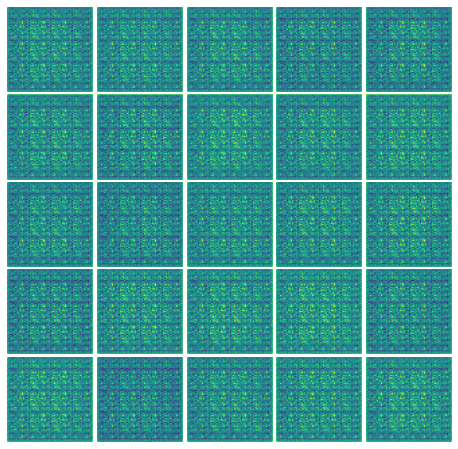

In [15]:
#Plot sample of the first epoch
plot_samples(samples, epoch=0)

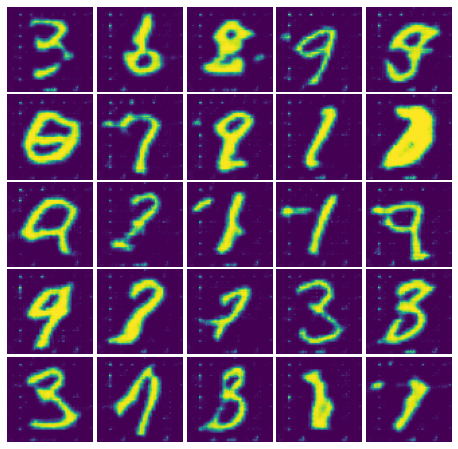

In [16]:
#Plot sample of the last epoch
plot_samples(samples)